In [1]:
import lab2_landmarks as l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm

Using TensorFlow backend.


First, we have to extract the features from each of the images and split them into training, validation, and test sets. Feature extraction is done using dlib, which I called from the lab2_landmarks file given in lab 2 of this course. Once the features had been extracted, I used scikit-learn to split the dataset into a 60-20-20 train-val-test split.

In [2]:
def get_data():
    X, y = l2.extract_features_labels()
    #Y = np.array([y, -(y - 1)]).T
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

    X_train_final = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
    X_val_final = X_val.reshape(X_val.shape[0],X_val.shape[1]*X_val.shape[2])
    X_test_final = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

    return X_train_final, y_train, X_val_final, y_val, X_test_final, y_test

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = get_data()

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(2877, 136)
(2877,)
(959, 136)
(959,)
(959, 136)
(959,)


In [5]:
def trainSVM(training_images, training_labels, test_images, test_labels, lambd, degreeInput=3, kernelInput='rbf'):
    classifier = svm.SVC(C=lambd, kernel=kernelInput, degree=degreeInput, gamma='auto')
    classifier.fit(training_images, training_labels)
    pred = classifier.predict(test_images)
    
    #accuracy = accuracy_score(test_labels, pred)
    #print("Accuracy:", accuracy_score(test_labels, pred))
    #print(pred)
    
    return pred

In [6]:
def crossValidation(X_train, y_train, X_val, y_val, degree=3, kernel='rbf'):
    lambda_vec = np.array([0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    
    error_train = np.zeros(len(lambda_vec))
    error_val = np.zeros(len(lambda_vec))
    
    for i in range(len(lambda_vec)):
        lambd = lambda_vec[i]
        y_train_pred = trainSVM(X_train, y_train, X_train, y_train, lambd, degreeInput=degree, kernelInput=kernel)
        y_val_pred = trainSVM(X_train, y_train, X_val, y_val, lambd, degreeInput=degree, kernelInput=kernel)
        
        error_train[i] = log_loss(y_train, y_train_pred)
        error_val[i] = log_loss(y_val, y_val_pred)

    print('Training Error:', error_train)
    print('Validation Error:', error_val)

    minErrorIndex = np.argmin(error_val)
    minError = np.amin(error_val)
    print('Min Validation Error Value:', minError)
    print('Ideal Lambda:', lambda_vec[minErrorIndex])
    
    plt.plot(lambda_vec, error_train, label='Train')
    plt.plot(lambda_vec, error_val, label='Cross Validation')
    plt.legend()
    plt.xlabel('lambda')
    plt.ylabel('Error')
    plt.title('Validation Curve')
    plt.show()    
        
    return lambda_vec[minErrorIndex], minError

In [7]:
def learningCurve(X_train, y_train, X_val, y_val, lambd, degree=3, kernel='rbf'):
        m = X_train.shape[0]
        error_train = np.zeros(int(m/10))
        error_val = np.zeros(int(m/10))
        
        for i in range(10, m, 10):
            y_train_pred = trainSVM(X_train[0:i], y_train[0:i], X_train[0:i], y_train[0:i], lambd, degreeInput=degree, kernelInput=kernel)
            y_val_pred = trainSVM(X_train[0:i], y_train[0:i], X_val, y_val, lambd, degreeInput=degree, kernelInput=kernel)
            
            error_train[int((i-10)/10)] = log_loss(y_train[0:i], y_train_pred)
            error_val[int((i-10)/10)] = log_loss(y_val, y_val_pred)
            
        plt.plot(np.arange(10, m, 10), error_train, label='Train')
        plt.plot(np.arange(10, m, 10), error_val, label='Cross Validation')
        plt.legend()
        plt.xlabel('Number of Training Examples')
        plt.ylabel('Error')
        plt.title('Learning Curve')
        plt.show()
        
        return None

# Linear Test

Training Error: [3.0133175  2.74920145 2.42506305 2.38904792 2.25699115 2.3770439
 2.24498545 2.2810017  2.29300711]
Validation Error: [3.09735345 2.98930472 2.55711899 2.59313607 2.62915064 2.80923018
 2.98930889 2.88126017 2.91727641]
Min Validation Error Value: 2.557118990575146
Ideal Lambda: 0.01


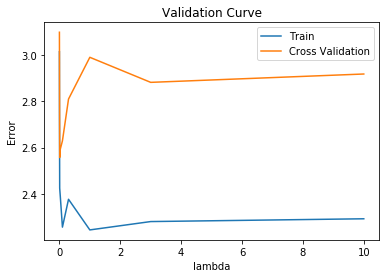

In [8]:
lambdaLinear = crossValidation(X_train, y_train, X_val, y_val,kernel='linear')[0]

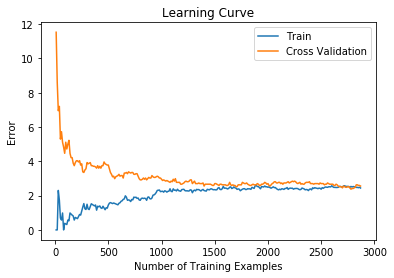

In [9]:
learningCurve(X_train, y_train, X_val, y_val, lambdaLinear, kernel='linear')

In [10]:
pred_test_linear=trainSVM(X_train, y_train, X_test, y_test, lambdaLinear, kernelInput='linear')
print('Accuracy:', accuracy_score(y_test, pred_test_linear))
print(classification_report(y_test, pred_test_linear))

Accuracy: 0.9280500521376434
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93       516
         1.0       0.91      0.94      0.92       443

    accuracy                           0.93       959
   macro avg       0.93      0.93      0.93       959
weighted avg       0.93      0.93      0.93       959



# Polynomial Test

In [13]:
def degreeCheck(X_train, y_train, X_val, y_val, kernel='poly'):
    degree_vec = np.array([1, 2])
    
    lambdaPoly = np.zeros(len(degree_vec))
    minError = np.zeros(len(degree_vec))
    
    for i in range(len(degree_vec)):
        degree = degree_vec[i]
        lambdaPoly[i], minError[i] = crossValidation(X_train, y_train, X_val, y_val, degree=degree, kernel=kernel)

    print('Ideal Lambdas:', lambdaPoly)
    print('Minimum Validation Errors:', minError)

    minminErrorIndex = np.argmin(minError)
    idealLambda = lambdaPoly[minminErrorIndex]
    print('Ideal Degree:', degree_vec[minminErrorIndex])
    print('Ideal Degree Lambda:', idealLambda)
    
    plt.plot(degree_vec, minError, label='Degree')
    plt.xlabel('Degree')
    plt.ylabel('Minimum Error')
    plt.title('Polynomial Validation Curve')
    plt.show()    
        
    return degree_vec[minminErrorIndex], idealLambda

Training Error: [6.65088984 4.63401503 3.87769229 3.31344868 3.12136372 2.82123365
 2.59313523 2.30501141 2.28100142]
Validation Error: [6.95101796 5.18624795 4.03375156 3.42148962 3.24141508 3.02532013
 2.62914981 2.62915064 2.73719853]
Min Validation Error Value: 2.629149806831477
Ideal Lambda: 1.0


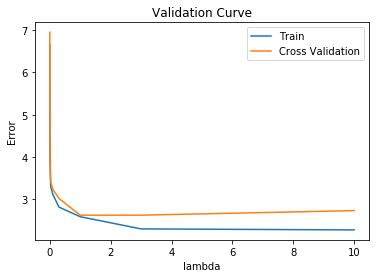

Training Error: [2.10092243 1.89683095 1.88482776 2.1009241  2.23298032 2.29300767
 2.38905014 2.19696463 2.30501225]
Validation Error: [2.62915398 2.7372002  2.70118896 2.95330015 3.09736345 3.20541551
 3.20541218 2.91728308 3.1693976 ]
Min Validation Error Value: 2.629153975744043
Ideal Lambda: 0.001


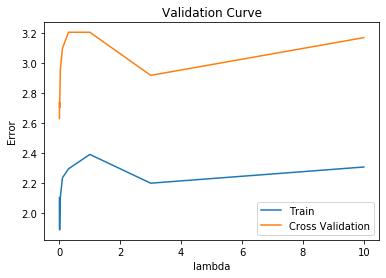

Ideal Lambdas: [1.    0.001]
Minimum Validation Errors: [2.62914981 2.62915398]
Ideal Degree: 1
Ideal Degree Lambda: 1.0


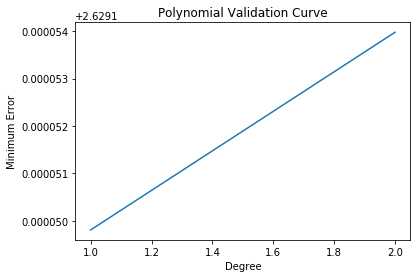

In [14]:
polyDegree, lambdaPoly = degreeCheck(X_train, y_train, X_val, y_val, kernel='poly')

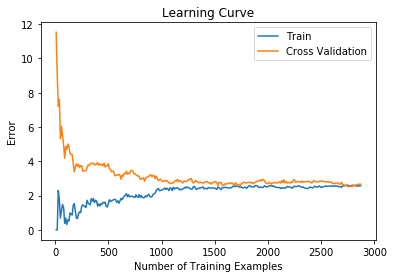

In [15]:
learningCurve(X_train, y_train, X_val, y_val, lambdaPoly, degree=polyDegree, kernel='poly')

In [16]:
pred_test_poly=trainSVM(X_train, y_train, X_test, y_test, lambdaPoly, degreeInput=polyDegree, kernelInput='poly')
print('Accuracy:', accuracy_score(y_test, pred_test_poly))
print(classification_report(y_test, pred_test_poly))

Accuracy: 0.9290928050052137
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93       516
         1.0       0.91      0.93      0.92       443

    accuracy                           0.93       959
   macro avg       0.93      0.93      0.93       959
weighted avg       0.93      0.93      0.93       959



# RBF Test

Training Error: [1.71073189e+01 1.71073189e+01 1.71073189e+01 1.71073189e+01
 1.68912264e+01 5.16222517e-01 1.20051360e-02 9.99200722e-16
 9.99200722e-16]
Validation Error: [17.97168866 17.97168866 17.97168866 17.97168866 17.86364243 11.09275821
  5.97863863  5.8705899   5.8705899 ]
Min Validation Error Value: 5.870589900447215
Ideal Lambda: 3.0


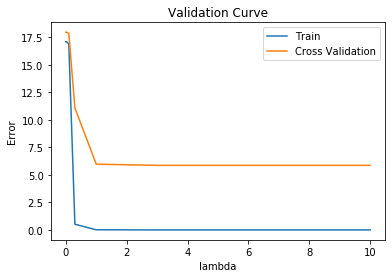

In [17]:
lambdaRBF = crossValidation(X_train, y_train, X_val, y_val)[0]

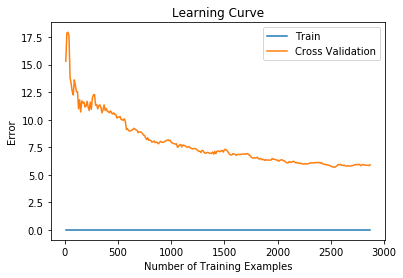

In [18]:
learningCurve(X_train, y_train, X_val, y_val, lambdaRBF)

In [19]:
pred_test_rbf=trainSVM(X_train, y_train, X_test, y_test, lambdaRBF)
print('Accuracy:', accuracy_score(y_test, pred_test_rbf))
print(classification_report(y_test, pred_test_rbf))

Accuracy: 0.8362877997914494
              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84       516
         1.0       0.79      0.88      0.83       443

    accuracy                           0.84       959
   macro avg       0.84      0.84      0.84       959
weighted avg       0.84      0.84      0.84       959

